<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/Walk_on_Boundary_and_BIEM/adamstepWOB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [605]:
import jax
from jax import lax
from jax import random

import jax.numpy as jnp
import numpy as np

import time

import matplotlib.pyplot as plt
import pandas as pd

In [606]:
'''
signed distance function of the domain
'''
@jax.jit
def signDistance(p):
  return jnp.linalg.norm(p,ord=2,axis=0) - 1 # unit sphere

In [607]:
'''
bounding box diameter
'''
@jax.jit
def box():
  return 2

In [608]:
'''
Dirchlet boundary condition
'''
@jax.jit
def boundaryCond(p):
  return 1.0*(p[1] > 0.0)

In [609]:
'''
the true solution
'''
def trueSoln(p):
  return 0.5 + np.arctan(2*p[1]/(1-np.power(p[0],2)-np.power(p[1],2)))/np.pi

# Walk on boundary method

In [610]:
'''
binary search to find boundary intersection
'''
@jax.jit
def bRootSearch(p0, p1, rootSteps, dir):
  p1 = p0 + p1 # need to center p1 at p0

  current = jnp.zeros((jnp.size(p0, 1), jnp.size(p0, 2)))

  def binaryStep(i, current):
    next = current + jnp.power(0.5,i+1)
    dist = signDistance(p0 + dir * next * (p1 - p0))
    return jnp.where(dist > 0, current, next)

  current = lax.fori_loop(0, rootSteps, binaryStep, current)
  
  return p0 + dir * current * (p1 - p0), current

In [611]:
'''
run the wob with binary search and calculate the estimator
'''
@jax.jit
def bwob(p0, p1, t, rootSteps):
  runningEst = jnp.zeros((jnp.size(p0,1),jnp.size(p0,2)))
  runningSign = 1

  pNext, tFirst = bRootSearch(p0, p1[0], rootSteps, 1)

  for p in p1[1:]:
    runningEst += runningSign * boundaryCond(pNext)
    runningSign *= -1
    pBack, tBack = bRootSearch(pNext, p, rootSteps, -1)
    pFor, tFor = bRootSearch(pNext, p, rootSteps, 1)
    pNext = jnp.where(tBack - tFor > 0, pBack, pFor)

  runningEst *= 2
  runningEst += runningSign * boundaryCond(pNext)
  return runningEst

In [612]:
'''
false position method to find boundary intersection
'''
@jax.jit
def fpRootSearch(p0, p1, rootSteps, dir):
  p1 = p0 + p1 # need to center p1 at p0

  t = (jnp.zeros((jnp.size(p0, 1), jnp.size(p0, 2))), 
       jnp.ones((jnp.size(p0, 1), jnp.size(p0, 2))))

  def adamStep(i, t):
    v1 = signDistance(p0 + dir * t[1] * (p1 - p0))
    v0 = jnp.where(t[0] == 0, -v1, signDistance(p0 + dir * t[0] * (p1 - p0)))
    next = (t[0] * v1 - t[1] * v0) / (v1 - v0)
    dist = signDistance(p0 + dir * next * (p1 - p0))

    new_t0 = jnp.where(dist > 0, t[0], next)
    new_t0 = jnp.where(jnp.isnan(new_t0), t[0], new_t0)
    new_t1 = jnp.where(dist < 0, t[1], next)
    new_t1 = jnp.where(jnp.isnan(new_t1), t[1], new_t1)
    
    return (new_t0, new_t1)

  t = lax.fori_loop(0, rootSteps, adamStep, t)
  v1 = signDistance(p0 + dir * t[1] * (p1 - p0))
  v0 = jnp.where(t[0] == 0, -v1, signDistance(p0 + dir * t[0] * (p1 - p0)))
  tfinal = jnp.where(jnp.abs(v1) > jnp.abs(v0), t[0], t[1])

  return p0 + dir * tfinal * (p1 - p0), tfinal # return the roots, t-values

In [613]:
'''
run the wob with false position and calculate the estimator
'''
@jax.jit
def fpwob(p0, p1, t, rootSteps):
  runningEst = jnp.zeros((jnp.size(p0,1),jnp.size(p0,2)))
  runningSign = 1

  pNext, tFirst = fpRootSearch(p0, p1[0], rootSteps, 1)

  for p in p1[1:]:
    runningEst += runningSign * boundaryCond(pNext)
    runningSign *= -1
    pBack, tBack = fpRootSearch(pNext, p, rootSteps, -1)
    pFor, tFor = fpRootSearch(pNext, p, rootSteps, 1)
    pNext = jnp.where(tBack - tFor > 0, pBack, pFor)

  runningEst *= 2
  runningEst += runningSign * boundaryCond(pNext)
  return runningEst

In [614]:
'''
setup the wob
'''
def computeSoln(t, rootSteps, batches, p, key, rootSearch='fp'):
  p = p.transpose()
  p = jnp.reshape(p, (jnp.size(p,0), jnp.size(p,1), 1))
  p0 = jnp.tile(p, (1,1,batches))

  # generate random directions in n-dimensions
  p1 = random.normal(key, shape=(t, jnp.size(p, 0), jnp.size(p, 1), batches))
  normalize = jnp.linalg.norm(p1, ord=2, axis=1, keepdims=True)
  p1 = box() * jnp.divide(p1, normalize)

  if (rootSearch == 'b'):
    ans = bwob(p0, p1, t, rootSteps)
  else:
    ans = fpwob(p0, p1, t, rootSteps)
  return jnp.mean(ans, 1, keepdims=True)

In [634]:
%%time
'''
testing code
'''
key = random.PRNGKey(int(time.time()))
x = jnp.array([[-0.3,0.5]])

y = computeSoln(10, 5, 100000, x, key)
print('solution:', y)
print('exact:', trueSoln(x[0]))

solution: [[0.80595]]
exact: 0.8143066174475078
CPU times: user 240 ms, sys: 32.2 ms, total: 272 ms
Wall time: 216 ms


# Analysis

In [635]:
'''
generate dataset with throw-out algorithm
WARNING: this algorithm gets worse in higher dimensions
'''
def generateData():
  key = random.PRNGKey(939)
  dimensions = 2
  samples = 1000
  x = random.uniform(key, minval=-box()/2, maxval=box()-box()/2, shape=(samples,dimensions))
  indices = jnp.where(signDistance(x.transpose()) < 0)
  #print('kept', len(x[indices]), 'out of', len(x))
  x = x[indices]
  
  return x

In [636]:
x = generateData()
y = trueSoln(jnp.transpose(x))
rootStepSize = jnp.arange(2, 25)
key = random.PRNGKey(909)

In [637]:
avg_error_a = jnp.zeros(23)
time_a = jnp.zeros(23)

for rootStep in rootStepSize:
  start = time.time()
  y_hat = jnp.squeeze(computeSoln(10, rootStep, 10000, x, key))
  time_a = time_a.at[rootStep-2].set(time.time() - start)
  error = jnp.abs(y - y_hat)
  avg_error_a = avg_error_a.at[rootStep-2].set(jnp.mean(error))

In [640]:
avg_error_b = jnp.zeros(23)
time_b = jnp.zeros(23)

for rootStep in rootStepSize:
  start = time.time()
  y_hat = jnp.squeeze(computeSoln(10, rootStep, 10000, x, key, rootSearch='b'))
  time_b = time_b.at[rootStep-2].set(time.time() - start)
  error = jnp.abs(y - y_hat)
  avg_error_b = avg_error_b.at[rootStep-2].set(jnp.mean(error))

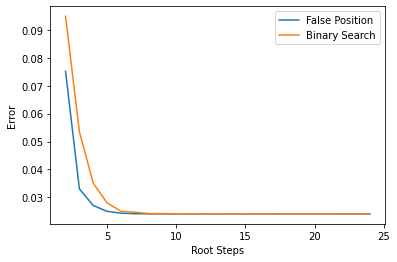

In [641]:
plt.plot(rootStepSize, avg_error_a, label='False Position')
plt.plot(rootStepSize, avg_error_b, label='Binary Search')
plt.xlabel('Root Steps')
plt.ylabel('Error')
plt.legend()

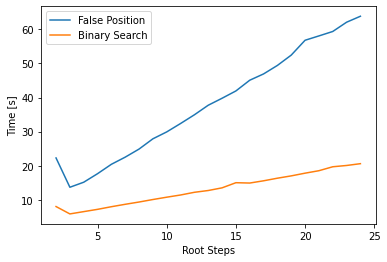

In [642]:
plt.plot(rootStepSize, time_a, label='False Position')
plt.plot(rootStepSize, time_b, label='Binary Search')
plt.xlabel('Root Steps')
plt.ylabel('Time [s]')
plt.legend()